## Imports

In [ ]:
import os
import json
import shutil
import random
from collections import defaultdict, Counter

import cv2
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
from matplotlib import pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Define paths and create necessary directories

In [ ]:
DATA_ROOT = "/kaggle/input/tt100k-2021/tt100k_2021"
OUT_ROOT = "/kaggle/working/tt100k_yolo"

ANN_PATH = os.path.join(DATA_ROOT, "annotations_all.json")

IMG_TRAIN = f"{OUT_ROOT}/images/train"
IMG_VAL = f"{OUT_ROOT}/images/val"
LBL_TRAIN = f"{OUT_ROOT}/labels/train"
LBL_VAL = f"{OUT_ROOT}/labels/val"

for p in [IMG_TRAIN, IMG_VAL, LBL_TRAIN, LBL_VAL]:
    os.makedirs(p, exist_ok=True)

## Load Annotations

In [21]:
with open(ANN_PATH, "r") as f:
    ann = json.load(f)

imgs = ann["imgs"]
print("Total annotated images:", len(imgs))

Total annotated images: 10592


## Explore and Visualize Class Distribution

In [16]:
classes = sorted({obj["category"] for img in imgs.values() for obj in img["objects"]})

class2id = {c: i for i, c in enumerate(classes)}
id2class = {i: c for c, i in class2id.items()}

print("Number of classes:", len(classes))
print(class2id)

Number of classes: 201
{'i1': 0, 'i10': 1, 'i11': 2, 'i12': 3, 'i13': 4, 'i14': 5, 'i15': 6, 'i2': 7, 'i2r': 8, 'i3': 9, 'i4': 10, 'i4l': 11, 'i5': 12, 'il100': 13, 'il110': 14, 'il50': 15, 'il60': 16, 'il70': 17, 'il80': 18, 'il90': 19, 'im': 20, 'ip': 21, 'iz': 22, 'p1': 23, 'p10': 24, 'p11': 25, 'p12': 26, 'p13': 27, 'p14': 28, 'p15': 29, 'p16': 30, 'p17': 31, 'p18': 32, 'p19': 33, 'p1n': 34, 'p2': 35, 'p20': 36, 'p21': 37, 'p23': 38, 'p24': 39, 'p25': 40, 'p26': 41, 'p27': 42, 'p28': 43, 'p29': 44, 'p3': 45, 'p4': 46, 'p5': 47, 'p6': 48, 'p7': 49, 'p8': 50, 'p9': 51, 'pa10': 52, 'pa12': 53, 'pa13': 54, 'pa14': 55, 'pa18': 56, 'pa6': 57, 'pa8': 58, 'pb': 59, 'pbm': 60, 'pbp': 61, 'pc': 62, 'pcd': 63, 'pcl': 64, 'pclr': 65, 'pcr': 66, 'pcs': 67, 'pctl': 68, 'pdd': 69, 'pg': 70, 'ph1.8': 71, 'ph2': 72, 'ph2.1': 73, 'ph2.2': 74, 'ph2.4': 75, 'ph2.5': 76, 'ph2.6': 77, 'ph2.8': 78, 'ph2.9': 79, 'ph3': 80, 'ph3.2': 81, 'ph3.3': 82, 'ph3.5': 83, 'ph3.8': 84, 'ph4': 85, 'ph4.2': 86, 'ph4.3'

## Implementation: Stratified Split by Class Distribution

In [7]:
# Group images by their primary class (most common class in the image)
class_to_images = defaultdict(list)

for img_id, img_data in imgs.items():
    if not img_data["objects"]:
        continue
    # Get most common class in this image
    class_counts = {}
    for obj in img_data["objects"]:
        cat = obj["category"]
        class_counts[cat] = class_counts.get(cat, 0) + 1
    primary_class = max(class_counts, key=class_counts.get)
    class_to_images[primary_class].append((img_id, img_data))

# Split each class 80/20
train_items_stratified = []
val_items_stratified = []

random.seed(42)
for cls, img_list in class_to_images.items():
    random.shuffle(img_list)
    split = int(0.8 * len(img_list))
    train_items_stratified.extend(img_list[:split])
    val_items_stratified.extend(img_list[split:])

random.shuffle(train_items_stratified)
random.shuffle(val_items_stratified)

print(f"Stratified Train: {len(train_items_stratified)}")
print(f"Stratified Val: {len(val_items_stratified)}")

Stratified Train: 8404
Stratified Val: 2188


## Process and Convert Annotations to YOLO Format

In [8]:
def process_image(img_data, img_root, img_out, lbl_out):
    img_path = os.path.join(img_root, img_data["path"])
    if not os.path.exists(img_path):
        return

    img = Image.open(img_path)
    w, h = img.size

    # copy image
    shutil.copy(img_path, img_out)

    label_path = os.path.join(
        lbl_out, os.path.basename(img_path).replace(".jpg", ".txt")
    )

    with open(label_path, "w") as f:
        for obj in img_data["objects"]:
            cls_id = class2id[obj["category"]]
            b = obj["bbox"]

            xc = ((b["xmin"] + b["xmax"]) / 2) / w
            yc = ((b["ymin"] + b["ymax"]) / 2) / h
            bw = (b["xmax"] - b["xmin"]) / w
            bh = (b["ymax"] - b["ymin"]) / h

            f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")

In [9]:
for _, img_data in tqdm(train_items_stratified):
    process_image(img_data, DATA_ROOT, IMG_TRAIN, LBL_TRAIN)

for _, img_data in tqdm(val_items_stratified):
    process_image(img_data, DATA_ROOT, IMG_VAL, LBL_VAL)

100%|██████████| 2188/2188 [00:31<00:00, 70.36it/s]


## Create YOLO Dataset Configuration File

In [10]:
yaml_path = f"{OUT_ROOT}/data.yaml"

names = {i: cid for cid, i in class2id.items()}

yaml_text = f"""
    path: {OUT_ROOT}
    train: images/train
    val: images/val
    
    nc: {len(classes)}
    names: {names}
"""

with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("data.yaml created")

data.yaml created


## Sample Label Inspection

In [11]:
sample_lbl = os.listdir(LBL_TRAIN)[0]
print(open(os.path.join(LBL_TRAIN, sample_lbl)).read())

41 0.22141845703125002 0.4783705810546875 0.012569335937500009 0.018854443359375028



## Enhanced Training Configuration with Class Weights

In [12]:
model = YOLO("yolov8n.pt")

results = model.train(
    data=yaml_path,
    epochs=30,
    imgsz=640,
    batch=64,
    # Augmentation to help with class imbalance
    hsv_h=0.015,  # Hue augmentation
    hsv_s=0.7,  # Saturation
    hsv_v=0.4,  # Value
    degrees=10,  # Rotation
    translate=0.1,
    scale=0.5,
    fliplr=0.5,  # Horizontal flip
    mosaic=1.0,  # Mosaic augmentation
    optimizer="AdamW",
    lr0=0.001,
    weight_decay=0.0005,
    save_period=5,  # Save checkpoint every 5 epochs
    device=0,
    workers=4,
    verbose=True,
    plots=True,
)

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/tt100k_yolo/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0,

## Comprehensive Evaluation & Per-Class Performance

In [ ]:
# Load best model and evaluate
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Validate on validation set
metrics = model.val(data=yaml_path, split="val")

print(f"\nmAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

# Per-class metrics
print("\nPer-class AP50:")
if hasattr(metrics.box, "ap_class_index"):
    for idx, ap in zip(metrics.box.ap_class_index, metrics.box.ap50):
        class_name = id2class.get(int(idx), f"class_{idx}")
        print(f"  {class_name}: {ap:.4f}")

Ultralytics 8.3.247 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,371,327 parameters, 0 gradients, 9.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3157.9±444.7 MB/s, size: 1011.4 KB)
val: Scanning /kaggle/working/tt100k_yolo/labels/val.cache... 2188 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2188/2188 3.3Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 137/137 4.6it/s 29.9s0.2s
                   all       2188       5662      0.573      0.273      0.316      0.249
                    i1          2          2       0.97          1      0.995      0.746
                   i10         14         14      0.427      0.357      0.395      0.309
                   i11          1          1          1          0     0.0355     0.0284
                   i12          3          4      0.338        0.5      0.554      0.468
               

## Analyze Performance: Rare vs Common Classes

Common classes (top 20): 20
Rare classes (bottom 25%): 43

Average AP50 for common classes: 0.6583
Average AP50 for rare classes: 0.1198


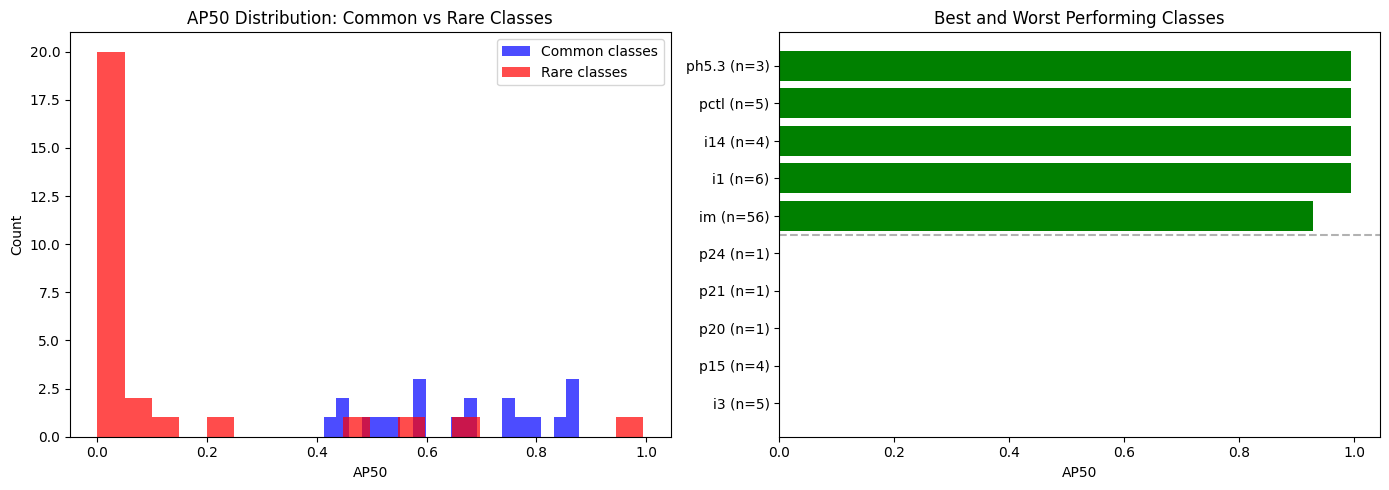


Worst performing classes:
  i3: AP50=0.0000, instances=5
  p15: AP50=0.0000, instances=4
  p20: AP50=0.0000, instances=1
  p21: AP50=0.0000, instances=1
  p24: AP50=0.0000, instances=1

Best performing classes:
  im: AP50=0.9275, instances=56
  i1: AP50=0.9950, instances=6
  i14: AP50=0.9950, instances=4
  pctl: AP50=0.9950, instances=5
  ph5.3: AP50=0.9950, instances=3


In [ ]:
# Count instances per class from training labels
class_counts = Counter()
for label_file in os.listdir(LBL_TRAIN):
    with open(os.path.join(LBL_TRAIN, label_file)) as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

# Categorize classes by frequency
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
common_classes = [c for c, cnt in sorted_counts[:20]]  # Top 20
rare_classes = [
    c
    for c, cnt in sorted_counts
    if cnt < np.percentile([c for _, c in sorted_counts], 25)
]

print(f"Common classes (top 20): {len(common_classes)}")
print(f"Rare classes (bottom 25%): {len(rare_classes)}")

# Compare performance
if hasattr(metrics.box, "ap_class_index") and hasattr(metrics.box, "ap50"):
    common_ap = [
        ap
        for idx, ap in zip(metrics.box.ap_class_index, metrics.box.ap50)
        if int(idx) in common_classes
    ]
    rare_ap = [
        ap
        for idx, ap in zip(metrics.box.ap_class_index, metrics.box.ap50)
        if int(idx) in rare_classes
    ]

    print(f"\nAverage AP50 for common classes: {np.mean(common_ap):.4f}")
    print(f"Average AP50 for rare classes: {np.mean(rare_ap):.4f}")

    # Visualize
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(common_ap, bins=20, alpha=0.7, label="Common classes", color="blue")
    ax[0].hist(rare_ap, bins=20, alpha=0.7, label="Rare classes", color="red")
    ax[0].set_xlabel("AP50")
    ax[0].set_ylabel("Count")
    ax[0].set_title("AP50 Distribution: Common vs Rare Classes")
    ax[0].legend()

    # Top and bottom performers
    all_results = [
        (int(idx), ap, id2class.get(int(idx), f"cls_{idx}"), class_counts[int(idx)])
        for idx, ap in zip(metrics.box.ap_class_index, metrics.box.ap50)
    ]
    all_results.sort(key=lambda x: x[1])

    worst_5 = all_results[:5]
    best_5 = all_results[-5:]

    ax[1].barh(
        range(10), [x[1] for x in worst_5 + best_5], color=["red"] * 5 + ["green"] * 5
    )
    ax[1].set_yticks(range(10))
    ax[1].set_yticklabels([f"{x[2]} (n={x[3]})" for x in worst_5 + best_5])
    ax[1].set_xlabel("AP50")
    ax[1].set_title("Best and Worst Performing Classes")
    ax[1].axhline(4.5, color="black", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nWorst performing classes:")
    for cls_id, ap, name, count in worst_5:
        print(f"  {name}: AP50={ap:.4f}, instances={count}")

    print("\nBest performing classes:")
    for cls_id, ap, name, count in best_5:
        print(f"  {name}: AP50={ap:.4f}, instances={count}")

## Visualize Predictions with Confidence Scores


61448.jpg:
  i4: 0.94
  pne: 0.85
  pn: 0.63
  p10: 0.46
  pl40: 0.41
  pl40: 0.40
  p11: 0.37

33700.jpg:
  p23: 0.94

60144.jpg:
  pm30: 0.39

1172.jpg:
  pm20: 0.56
  p1: 0.28


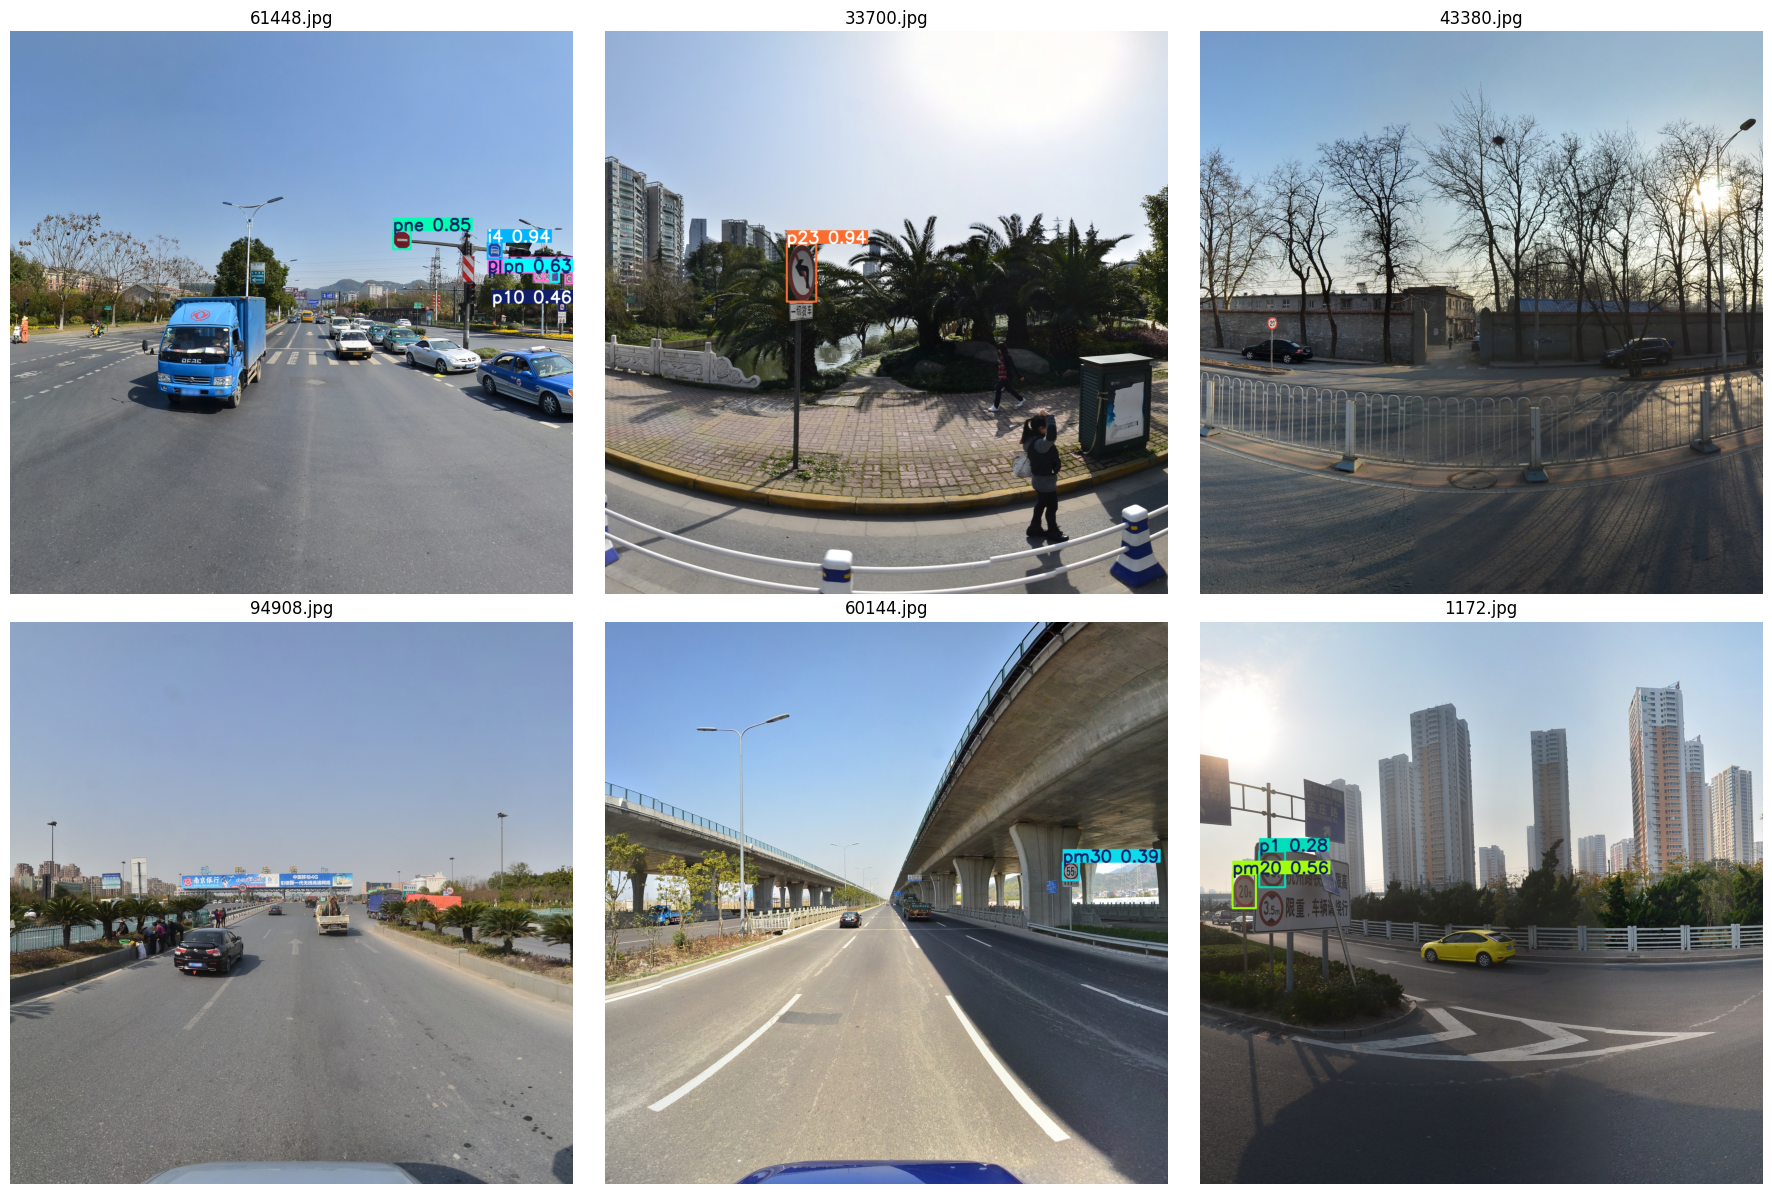

In [ ]:
# Visualize predictions on validation images
val_images = [os.path.join(IMG_VAL, f) for f in os.listdir(IMG_VAL)[:6]]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(val_images):
    # Run prediction
    results = model.predict(img_path, conf=0.25, verbose=False)

    # Get annotated image
    annotated = results[0].plot()

    # Convert BGR to RGB
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(annotated_rgb)
    axes[idx].set_title(f"{os.path.basename(img_path)}")
    axes[idx].axis("off")

    # Print detection summary
    if len(results[0].boxes) > 0:
        print(f"\n{os.path.basename(img_path)}:")
        for box in results[0].boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = id2class.get(cls_id, f"class_{cls_id}")
            print(f"  {class_name}: {conf:.2f}")

plt.tight_layout()
plt.show()

## Test on Real-World Images

Running inference on real-world test images...

image 1/2 /home/avinna/Personal/TrafficSign/real_test/Speed_Limit_sign_in_H01_Nepal.jpg: 640x544 1 pl40, 136.5ms
image 2/2 /home/avinna/Personal/TrafficSign/real_test/road-signs-with-chinese-text-in-beijing-china-do-not-sound-horn-2HT715H.jpg: 512x640 2 p11s, 2 p26s, 1 p5, 1 pn, 19.5ms
Speed: 4.8ms preprocess, 78.0ms inference, 6.2ms postprocess per image at shape (1, 3, 512, 640)
Results saved to /home/avinna/Personal/TrafficSign/runs/detect/predict
3 labels saved to /home/avinna/Personal/TrafficSign/runs/detect/predict/labels

Predictions saved to: /home/avinna/Personal/TrafficSign/runs/detect/predict

Real-world test statistics:
  Total detections: 7
  Average confidence: 0.504
  Median confidence: 0.432
  Min confidence: 0.255


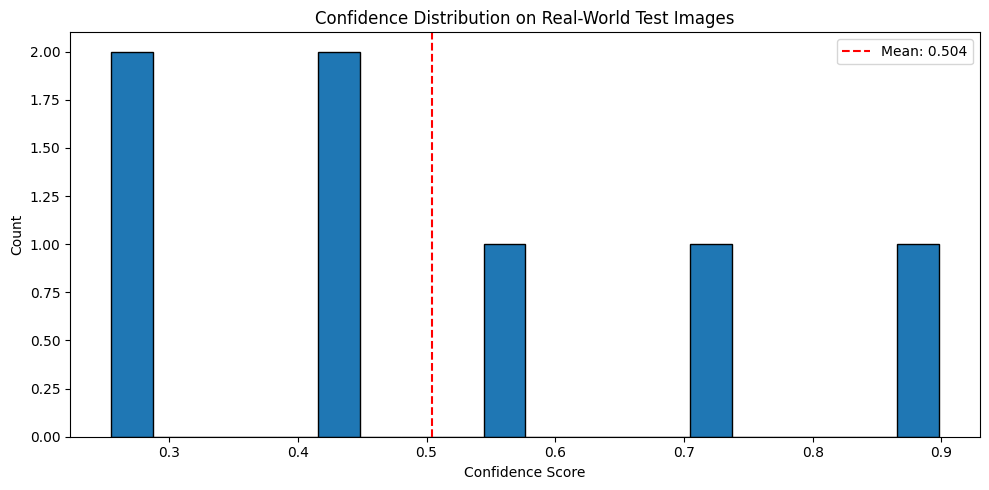


Detected classes in real-world images:
  p11: 2
  p26: 2
  pl40: 1
  p5: 1
  pn: 1


In [ ]:
# Test on real_test folder if it exists
if os.path.exists("real_test"):
    print("Running inference on real-world test images...")
    results = model.predict(
        source="real_test",
        conf=0.25,
        save=True,
        save_txt=True,  # Save predictions in YOLO format
        save_conf=True,  # Include confidence scores
    )

    print(f"\nPredictions saved to: {results[0].save_dir}")

    # Analyze confidence distribution on real images
    all_confidences = []
    all_classes = []

    for r in results:
        if len(r.boxes) > 0:
            all_confidences.extend([float(conf) for conf in r.boxes.conf])
            all_classes.extend([int(cls) for cls in r.boxes.cls])

    if all_confidences:
        print(f"\nReal-world test statistics:")
        print(f"  Total detections: {len(all_confidences)}")
        print(f"  Average confidence: {np.mean(all_confidences):.3f}")
        print(f"  Median confidence: {np.median(all_confidences):.3f}")
        print(f"  Min confidence: {np.min(all_confidences):.3f}")

        # Confidence distribution
        plt.figure(figsize=(10, 5))
        plt.hist(all_confidences, bins=20, edgecolor="black")
        plt.xlabel("Confidence Score")
        plt.ylabel("Count")
        plt.title("Confidence Distribution on Real-World Test Images")
        plt.axvline(
            np.mean(all_confidences),
            color="red",
            linestyle="--",
            label=f"Mean: {np.mean(all_confidences):.3f}",
        )
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Class distributiorunsn in real test
        class_dist = Counter(all_classes)
        print(f"\nDetected classes in real-world images:")
        for cls_id, count in class_dist.most_common(10):
            print(f"  {id2class.get(cls_id, f'class_{cls_id}')}: {count}")
else:
    print("real_test folder not found. Skipping real-world testing.")

## Display predicted images

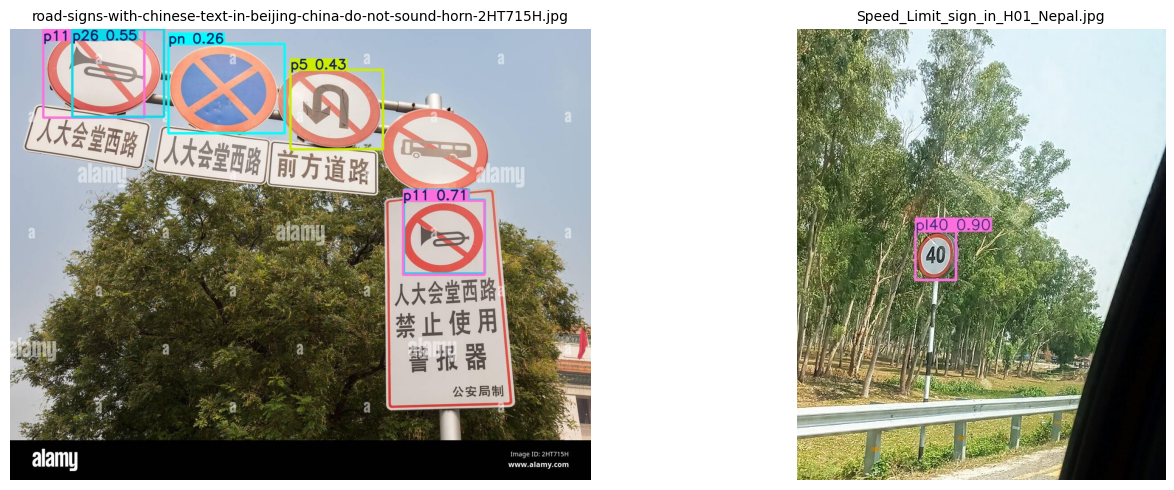


Displaying 2 predicted images from: runs/detect/predict


In [ ]:
# Get all predicted images
pred_dir = "/kaggle/working/runs/detect/predict"
pred_images = glob.glob(f"{pred_dir}/*.jpg") + glob.glob(f"{pred_dir}/*.JPG")

if pred_images:
    n_images = len(pred_images)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_images > 1 else [axes]

    for idx, img_path in enumerate(pred_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(os.path.basename(img_path), fontsize=10)
        axes[idx].axis("off")

    # Hide any unused subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\nDisplaying {n_images} predicted images from: {pred_dir}")
else:
    print(f"No predicted images found in {pred_dir}")